# Project Psyched: A Closer Look Into Reproducibility In Psychological Research

## Data Analysis & Visualization Script: Part 2 - Test Statistics & Recalcuating P-Values
This script for data analysis and visualization after data has been scraped from TDM Studio. This part of the project utilizes the full corpus of both #1 and #2.

Author: Yuyang Zhong (2020). This work is licensed under a [Creative Commons BY-NC-SA 4.0 International
License][cc-by].

![CC BY-NC-SA 4.0][cc-by-shield]

[cc-by]: http://creativecommons.org/licenses/by/4.0/
[cc-by-shield]: https://img.shields.io/badge/license-CC--BY--NC--SA%204.0-blue

#### Setup & Imports

In [1]:
import json
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import ast

from scipy import stats

In [2]:
in_path = "../data/"
in_name = "stats_all.csv"

In [3]:
df = pd.read_csv(in_path + in_name, index_col=1).drop('Unnamed: 0', axis=1)
df.head()

,Original,Type,Sign,Reported p-value,Recalculated p-value
File,,,,,
614337945.xml,"t (41) = 4.10, p < .01",t,<,0.01,9.531027e-05
614337945.xml,"t (41) = −3.56, p < .01",t,<,0.01,9.995224e-01
614337945.xml,"t (41) = 8.21, p < .01",t,<,0.01,1.708961e-10
614337945.xml,"t (41) = 4.82, p < .01",t,<,0.01,9.987600e-06
614337945.xml,"t (41) = −2.57, p < .01",t,<,0.01,9.930493e-01


In [4]:
df.shape

(212589, 5)

In [5]:
df.index.value_counts()

1640024140.xml    404
2316529621.xml    320
2259585220.xml    224
1824548299.xml    170
614498611.xml     168
                 ... 
1647028914.xml      1
614429525.xml       1
614278383.xml       1
614328329.xml       1
1966162149.xml      1
Name: File, Length: 13220, dtype: int64

#### Import Metadata

In [6]:
meta = pd.read_csv(in_path + "metadata_all.csv", index_col=0)
meta = meta[['Journal', 'Date Published']]
meta.head()

,Journal,Date Published
614337945.xml,Journal of Personality and Social Psychology,1987-03-01
1647028895.xml,Journal of Personality and Social Psychology,2015-01-01
614404963.xml,Journal of Personality and Social Psychology,2002-07-01
614332724.xml,Journal of Personality and Social Psychology,1997-11-01
614304222.xml,Journal of Personality and Social Psychology,1990-11-01


#### Standardize Journal of Abnormal Psychology

In [7]:
meta['Journal'].value_counts()

American Psychologist                                                  13854
Journal of Applied Psychology                                           9960
Developmental Psychology                                                6757
Journal of Personality and Social Psychology                            6048
Journal of Abnormal Psychology                                          4656
Journal of Experimental Psychology: Learning, Memory, and Cognition     4171
The Journal of Abnormal Psychology                                       610
Journal of Experimental Social Psychology                                  1
Name: Journal, dtype: int64

In [8]:
meta['Journal'] = meta['Journal'].replace('The Journal of Abnormal Psychology', 'Journal of Abnormal Psychology')
meta['Journal'].value_counts()

American Psychologist                                                  13854
Journal of Applied Psychology                                           9960
Developmental Psychology                                                6757
Journal of Personality and Social Psychology                            6048
Journal of Abnormal Psychology                                          5266
Journal of Experimental Psychology: Learning, Memory, and Cognition     4171
Journal of Experimental Social Psychology                                  1
Name: Journal, dtype: int64

#### Merge metadata with statistics data frame

In [9]:
df_merged = df.merge(meta, how='left', left_index=True, right_index=True)
df_merged.head()

,Original,Type,Sign,Reported p-value,Recalculated p-value,Journal,Date Published
1011297993.xml,"F(1, 137) = 0.01, p = .906",f,=,0.9060,9.204905e-01,Journal of Applied Psychology,2012-09-01
1011297993.xml,"F(1, 139) = 2.46, p = .119",f,=,0.1190,1.190525e-01,Journal of Applied Psychology,2012-09-01
1011297999.xml,"F(1, 40) = 7.90, p < .01",f,<,0.0100,7.617572e-03,Journal of Personality and Social Psychology,2012-07-01
1011297999.xml,"F(1, 40) = 8.85, p < .01",f,<,0.0100,4.950714e-03,Journal of Personality and Social Psychology,2012-07-01
1011297999.xml,"F(1, 113) = 66.53, p < .0001",f,<,0.0001,5.296874e-13,Journal of Personality and Social Psychology,2012-07-01


In [10]:
df_merged.shape

(212589, 7)

In [11]:
df_merged['Journal'].value_counts()

Journal of Personality and Social Psychology                           98888
Journal of Experimental Psychology: Learning, Memory, and Cognition    42717
Developmental Psychology                                               35050
Journal of Abnormal Psychology                                         23075
Journal of Applied Psychology                                          12389
American Psychologist                                                    470
Name: Journal, dtype: int64

#### Erroneous p-values 

In [12]:
df_merged[df_merged['Reported p-value'] > 1].shape

(83, 7)

In [13]:
df_merged = df_merged[df_merged['Reported p-value'] <= 1]
df_merged.shape

(212506, 7)

#### We will only look at those that are `<` or `=`

<AxesSubplot:xlabel='Reported p-value', ylabel='Recalculated p-value'>

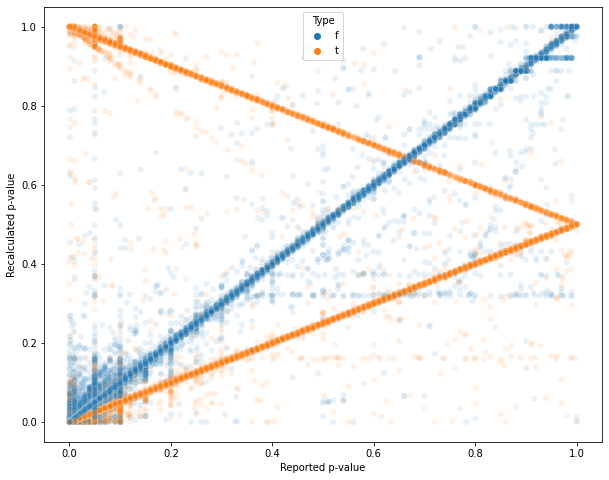

In [14]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x='Reported p-value', y='Recalculated p-value', 
                data=df_merged[(df_merged['Sign'] == '=') | (df_merged['Sign'] == '<')], 
                alpha=0.1, hue='Type')
# sns.lineplot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), color='green', linewidth=3, alpha=0.3);

#### Naive correction for one- and two-tail t-test p-values

In [15]:
df_stats = df_merged.reset_index()

for index, row in df_stats.iterrows():
    if row['Type'] == 't':
        p = row['Recalculated p-value']
        if p > 0.5:
            p = 1 - p
        df_stats.at[index, 'Recalculated p-value'] = p * 2

<AxesSubplot:xlabel='Reported p-value', ylabel='Recalculated p-value'>

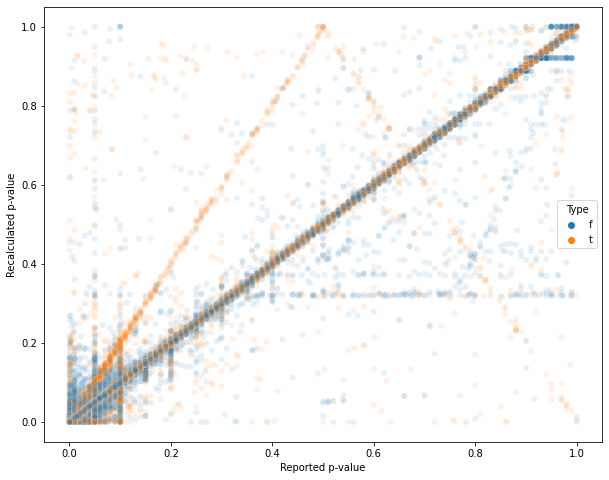

In [16]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x='Reported p-value', y='Recalculated p-value', 
                data=df_stats[(df_stats['Sign'] == '=') | (df_stats['Sign'] == '<')], 
                alpha=0.1, hue='Type')
# sns.lineplot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), color='green', linewidth=3, alpha=0.3);

#### Further correction of hose that should not have been doubled (with absolute tolerance of 0.01)

In [17]:
for index, row in df_stats.iterrows():
    if row['Type'] == 't':
        old_p = row['Reported p-value']
        new_p = row['Recalculated p-value']
        if (old_p >= 0.5) & np.isclose((1-old_p)*2, new_p, atol=0.01):
            df_stats.at[index, 'Recalculated p-value'] = 1-(new_p/2)
        elif (old_p < 0.5) & np.isclose(old_p*2, new_p, atol=0.01):
            df_stats.at[index, 'Recalculated p-value'] = new_p/2
        else:
            pass

<AxesSubplot:xlabel='Reported p-value', ylabel='Recalculated p-value'>

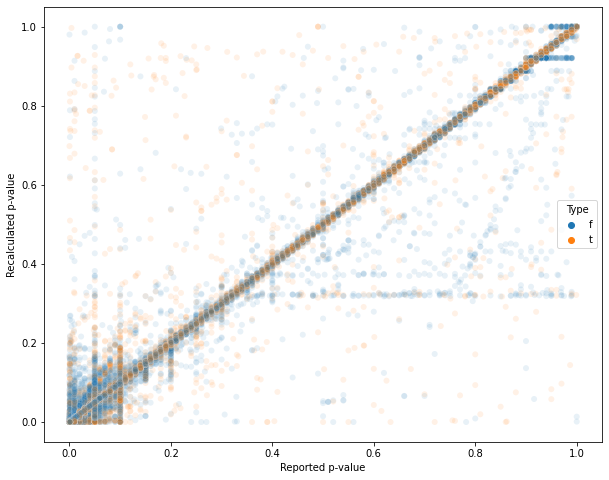

In [18]:
plt.figure(figsize=(10, 8))
sns.scatterplot(x='Reported p-value', y='Recalculated p-value', 
                data=df_stats[(df_stats['Sign'] == '=') | (df_stats['Sign'] == '<')], 
                alpha=0.1, hue='Type')
# sns.lineplot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), color='green', linewidth=3, alpha=0.3);

Text(0.5, 1.0, "Recalculated vs. Reported p-values, '=' only, n = 61520")

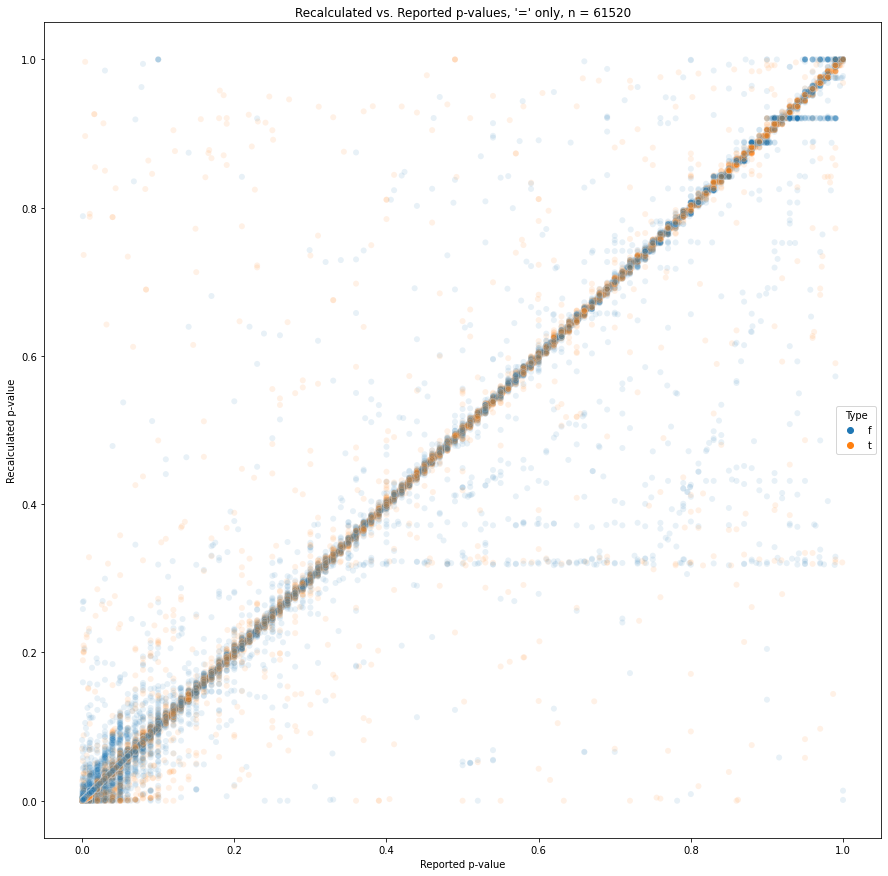

In [19]:
plt.figure(figsize=(15, 15))
sns.scatterplot(x='Reported p-value', y='Recalculated p-value', 
                data=df_stats[df_stats['Sign'] == '='], 
                alpha=0.1, hue='Type')
plt.title(f"Recalculated vs. Reported p-values, '=' only, n = {df_stats[df_stats['Sign'] == '='].shape[0]}")
# sns.lineplot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), color='green', linewidth=3, alpha=0.3);

Text(0.5, 1.0, "Recalculated vs. Reported p-values, '<' only, n = 143708")

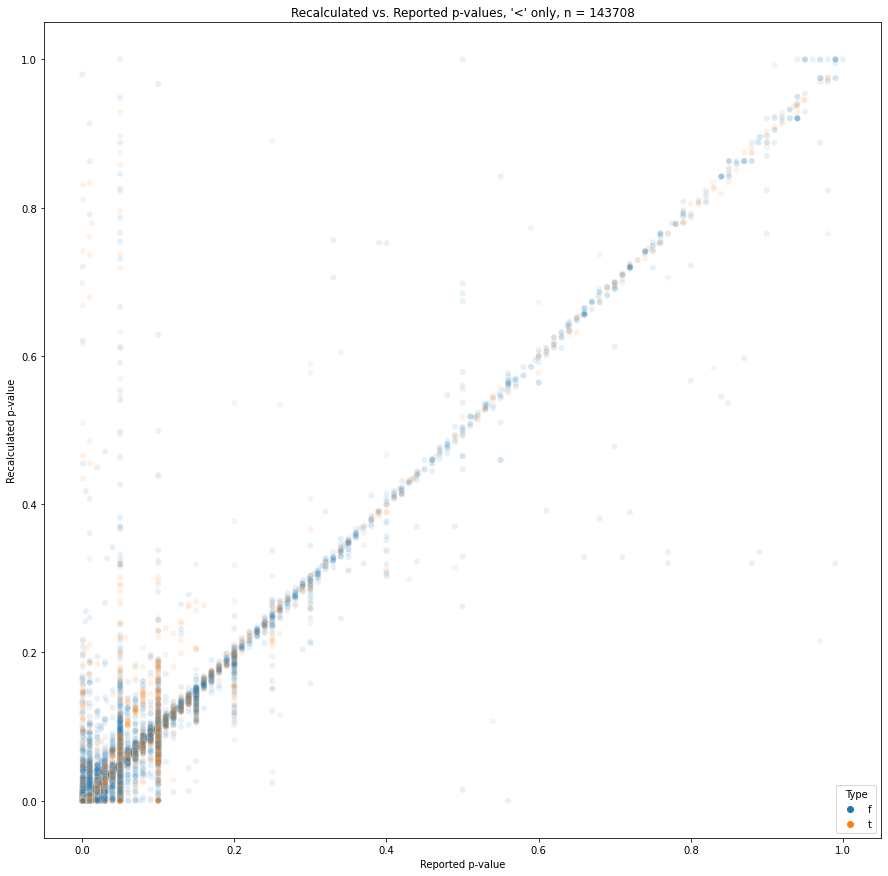

In [20]:
plt.figure(figsize=(15, 15))
sns.scatterplot(x='Reported p-value', y='Recalculated p-value', 
                data=df_stats[df_stats['Sign'] == '<'], 
                alpha=0.1, hue='Type')
plt.title(f"Recalculated vs. Reported p-values, '<' only, n = {df_stats[df_stats['Sign'] == '<'].shape[0]}")
# sns.lineplot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), color='green', linewidth=3, alpha=0.3);

#### Total insignificant recalculation from significant reported values

In [21]:
df_sig = df_stats[((df_stats['Reported p-value'] < 0.05) & ((df_stats['Sign'] == '=') | (df_stats['Sign'] == '<'))) 
         | ((df_stats['Reported p-value'] == 0.05) & (df_stats['Sign'] == '<'))]

In [22]:
sig_report = df_sig.shape[0]
print(f'Total number of reported significant p-value: {sig_report}')

Total number of reported significant p-value: 167261


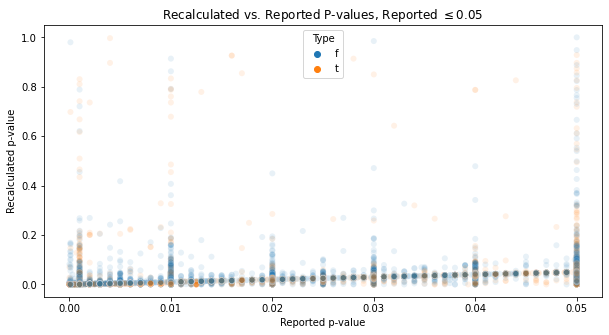

In [23]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x='Reported p-value', y='Recalculated p-value', 
                data=df_sig, 
                x_jitter=0.05, y_jitter=0.05,
                alpha=0.1, hue='Type')
plt.title(r'Recalculated vs. Reported P-values, Reported $\leq 0.05$');
# sns.lineplot(np.linspace(0, 0.05, 100), np.linspace(0, 0.05, 100), color='red', linewidth=3, alpha=1);

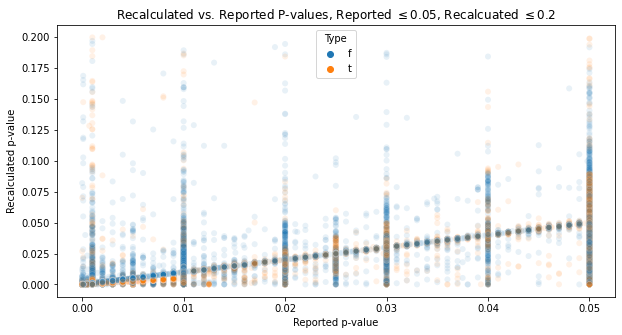

In [24]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x='Reported p-value', y='Recalculated p-value', 
                data=df_sig[df_sig['Recalculated p-value'] <=0.2], 
                x_jitter=0.05, y_jitter=0.05,
                alpha=0.1, hue='Type')
plt.title(r'Recalculated vs. Reported P-values, Reported $\leq 0.05$, Recalcuated $\leq 0.2$');
# sns.lineplot(np.linspace(0, 0.05, 100), np.linspace(0, 0.05, 100), color='red', linewidth=3, alpha=1);

In [25]:
non_sig_recal = df_sig[df_sig['Recalculated p-value'] >= 0.05].shape[0]
print(f'Total number of non-significant p-value after recalculation: {non_sig_recal}')
print(f'Percentage of non-significant p-value after recalculation: {round(non_sig_recal*100/sig_report, 4)}%')

Total number of non-significant p-value after recalculation: 2593
Percentage of non-significant p-value after recalculation: 1.5503%


In [26]:
count = 1

print('========== OVERALL AVERAGE ==========')
print(f'    Total number of reported significant p-value: {sig_report}')    
print(f'    Total number of non-significant p-value after recalculation: {non_sig_recal}')
print(f'    Percentage of non-significant p-value after recalculation: {round(non_sig_recal*100/sig_report, 4)}% \n')


print('========== JOURNAL AVERAGE ==========')
for journal in df_sig['Journal'].unique():
    sub_df = df_sig[df_sig['Journal'] == journal]
    
    sig_report = sub_df.shape[0]
    non_sig_recal = sub_df[sub_df['Recalculated p-value'] >= 0.05].shape[0]
    
    print(f'Journal {count}: {journal}')
    print(f'    Total number of reported significant p-value: {sig_report}')    
    print(f'    Total number of non-significant p-value after recalculation: {non_sig_recal}')
    print(f'    Percentage of non-significant p-value after recalculation: {round(non_sig_recal*100/sig_report, 4)}% \n')
    
    count += 1

========== OVERALL AVERAGE ==========
    Total number of reported significant p-value: 167261
    Total number of non-significant p-value after recalculation: 2593
    Percentage of non-significant p-value after recalculation: 1.5503% 

========== JOURNAL AVERAGE ==========
Journal 1: Journal of Personality and Social Psychology
    Total number of reported significant p-value: 78931
    Total number of non-significant p-value after recalculation: 1162
    Percentage of non-significant p-value after recalculation: 1.4722% 

Journal 2: Developmental Psychology
    Total number of reported significant p-value: 28732
    Total number of non-significant p-value after recalculation: 571
    Percentage of non-significant p-value after recalculation: 1.9873% 

Journal 3: Journal of Experimental Psychology: Learning, Memory, and Cognition
    Total number of reported significant p-value: 31257
    Total number of non-significant p-value after recalculation: 319
    Percentage of non-significa

#### Year Trend

In [27]:
df_sig['Year'] = pd.to_datetime(df_sig['Date Published']).dt.year
df_sig.shape

<ipython-input-27-260b06d4beb5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sig['Year'] = pd.to_datetime(df_sig['Date Published']).dt.year


(167261, 9)

In [28]:
df_sig_year = df_sig.dropna()
df_sig_year['Year'] = df_sig_year['Year'].apply(int)
df_sig_year.shape

<ipython-input-28-ce41e30896b6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sig_year['Year'] = df_sig_year['Year'].apply(int)


(167226, 9)

In [29]:
df_sig_year['Non Significant'] = df_sig_year['Recalculated p-value'] >= 0.05

<ipython-input-29-fa4e5ffd65ef>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sig_year['Non Significant'] = df_sig_year['Recalculated p-value'] >= 0.05


In [30]:
non_sig = df_sig_year.groupby(['Journal', 'Year']).sum()['Non Significant']
df_sig_year = df_sig_year.groupby(['Journal', 'Year']).count()['Reported p-value'].to_frame().reset_index()

In [31]:
df_sig_year['Non Significant'] = non_sig.values
df_sig_year['Percentage'] = df_sig_year['Non Significant']*100 / df_sig_year['Reported p-value']
df_sig_year['Rolling Average'] = df_sig_year['Percentage'].rolling(5).mean()

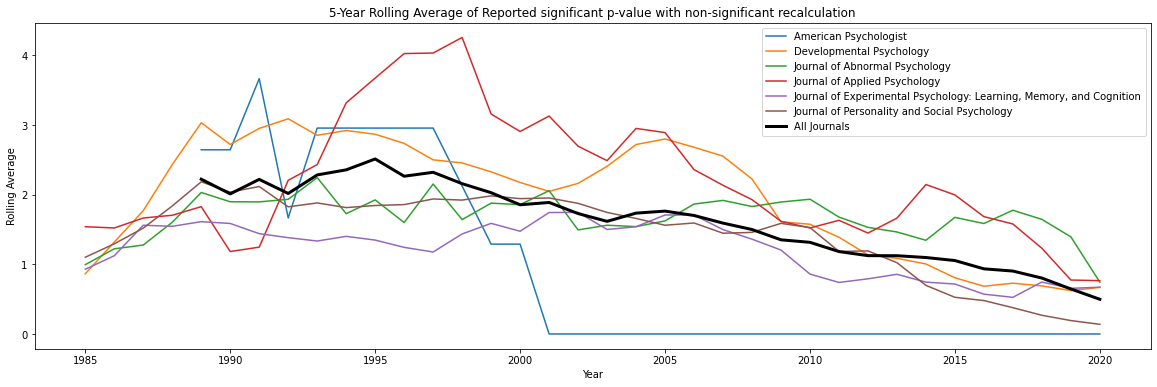

In [32]:
overall_rolling = df_sig_year.groupby('Year').mean()['Percentage'].rolling(5).mean()

plt.figure(figsize=(20,6))
sns.lineplot(x='Year', y='Rolling Average', hue='Journal', data=df_sig_year)
sns.lineplot(x=overall_rolling.index, y=overall_rolling.values, 
             label='All Journals',
             color='black',
             linewidth = 3
            )
plt.title('5-Year Rolling Average of Reported significant p-value with non-significant recalculation')
plt.legend();

#### Distribution of Mismatching p-values: 
Scenario 1: all value mismatch by 0.1

In [33]:
def is_mismatch01(reported, recalculated):
    return not np.isclose(reported, recalculated, atol=0.1)

In [34]:
df_sig['mismatch1'] = df_sig.apply(lambda x: is_mismatch01(x['Reported p-value'], x['Recalculated p-value']), axis=1)
df_sig.head()

<ipython-input-34-62f55a56175c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sig['mismatch1'] = df_sig.apply(lambda x: is_mismatch01(x['Reported p-value'], x['Recalculated p-value']), axis=1)


,index,Original,Type,Sign,Reported p-value,Recalculated p-value,Journal,Date Published,Year,mismatch1
2,1011297999.xml,"F(1, 40) = 7.90, p < .01",f,<,0.0100,7.617572e-03,Journal of Personality and Social Psychology,2012-07-01,2012,False
3,1011297999.xml,"F(1, 40) = 8.85, p < .01",f,<,0.0100,4.950714e-03,Journal of Personality and Social Psychology,2012-07-01,2012,False
4,1011297999.xml,"F(1, 113) = 66.53, p < .0001",f,<,0.0001,5.296874e-13,Journal of Personality and Social Psychology,2012-07-01,2012,False
5,1011297999.xml,"F(1, 113) = 31.60, p < .0001",f,<,0.0001,1.385165e-07,Journal of Personality and Social Psychology,2012-07-01,2012,False
6,1011297999.xml,"F(1, 113) = 11.89, p < .001",f,<,0.0010,7.938100e-04,Journal of Personality and Social Psychology,2012-07-01,2012,False


(4471,)


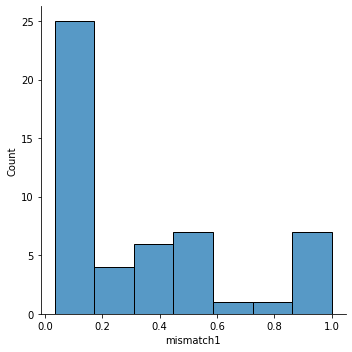

In [35]:
temp = df_sig[df_sig['Sign'] == '='].groupby('index').mean()['mismatch1']
print(temp.shape)
sns.displot(temp[temp > 0])

Scenario 2: all value mismatch by 0.05

In [36]:
def is_mismatch02(reported, recalculated):
    return not np.isclose(reported, recalculated, atol=0.05)

df_sig['mismatch2'] = df_sig.apply(lambda x: is_mismatch02(x['Reported p-value'], x['Recalculated p-value']), axis=1)
df_sig.head()

<ipython-input-36-ffda05a1fad0>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sig['mismatch2'] = df_sig.apply(lambda x: is_mismatch02(x['Reported p-value'], x['Recalculated p-value']), axis=1)


,index,Original,Type,Sign,Reported p-value,Recalculated p-value,Journal,Date Published,Year,mismatch1,mismatch2
2,1011297999.xml,"F(1, 40) = 7.90, p < .01",f,<,0.0100,7.617572e-03,Journal of Personality and Social Psychology,2012-07-01,2012,False,False
3,1011297999.xml,"F(1, 40) = 8.85, p < .01",f,<,0.0100,4.950714e-03,Journal of Personality and Social Psychology,2012-07-01,2012,False,False
4,1011297999.xml,"F(1, 113) = 66.53, p < .0001",f,<,0.0001,5.296874e-13,Journal of Personality and Social Psychology,2012-07-01,2012,False,False
5,1011297999.xml,"F(1, 113) = 31.60, p < .0001",f,<,0.0001,1.385165e-07,Journal of Personality and Social Psychology,2012-07-01,2012,False,False
6,1011297999.xml,"F(1, 113) = 11.89, p < .001",f,<,0.0010,7.938100e-04,Journal of Personality and Social Psychology,2012-07-01,2012,False,False


(4471,)


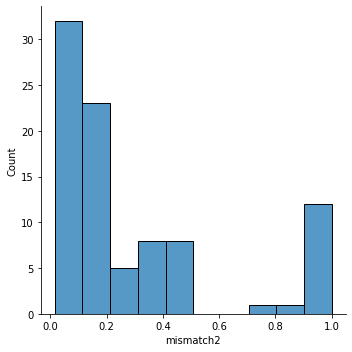

In [37]:
temp = df_sig[df_sig['Sign'] == '='].groupby('index').mean()['mismatch2']
print(temp.shape)
sns.displot(temp[temp > 0])

Scenario 3: all value mismatch by 0.01

In [38]:
def is_mismatch03(reported, recalculated):
    return not np.isclose(reported, recalculated, atol=0.01)

df_sig['mismatch3'] = df_sig.apply(lambda x: is_mismatch03(x['Reported p-value'], x['Recalculated p-value']), axis=1)
df_sig.head()

<ipython-input-38-a795157b52a6>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sig['mismatch3'] = df_sig.apply(lambda x: is_mismatch03(x['Reported p-value'], x['Recalculated p-value']), axis=1)


,index,Original,Type,Sign,Reported p-value,Recalculated p-value,Journal,Date Published,Year,mismatch1,mismatch2,mismatch3
2,1011297999.xml,"F(1, 40) = 7.90, p < .01",f,<,0.0100,7.617572e-03,Journal of Personality and Social Psychology,2012-07-01,2012,False,False,False
3,1011297999.xml,"F(1, 40) = 8.85, p < .01",f,<,0.0100,4.950714e-03,Journal of Personality and Social Psychology,2012-07-01,2012,False,False,False
4,1011297999.xml,"F(1, 113) = 66.53, p < .0001",f,<,0.0001,5.296874e-13,Journal of Personality and Social Psychology,2012-07-01,2012,False,False,False
5,1011297999.xml,"F(1, 113) = 31.60, p < .0001",f,<,0.0001,1.385165e-07,Journal of Personality and Social Psychology,2012-07-01,2012,False,False,False
6,1011297999.xml,"F(1, 113) = 11.89, p < .001",f,<,0.0010,7.938100e-04,Journal of Personality and Social Psychology,2012-07-01,2012,False,False,False


(4471,)


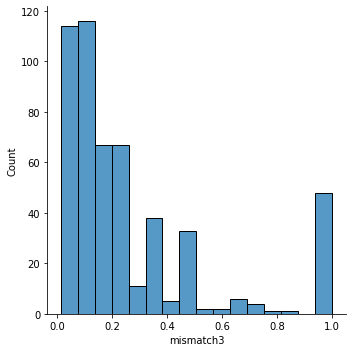

In [39]:
temp = df_sig[df_sig['Sign'] == '='].groupby('index').mean()['mismatch3']
print(temp.shape)
sns.displot(temp[temp > 0])